---
title: "ClimateDT-ROISelectionandDataAnalysis" 
subtitle: "This notebook shows how to request, access and work with Climate DT data selecting a region of interest via HDA"
author: "Author: Serena Avolio(EUMETSAT/Starion)"
tags: [HDA, ECMWF, earthkit, Digital Twin,ROI]
thumbnail: img/ECMWF.png 
license: MIT
copyright: "© 2026 EUMETSAT"
---

<!-- Optional: Add a JupyterHub launch link here. If you don’t have one, you can remove this block. -->

<div style="margin: 6px 0;">
  <a href="https://jupyter.central.data.destination-earth.eu/user-redirect/lab/tree/HDA/DestinE_DIgital_Twins/ClimateDT-ROISelectionandDataAnalysis.ipynb" target="_blank" style="text-decoration: none;">
    <span class="launch">🚀 Launch in JupyterHub</span>
  </a>
</div>


# Climate DT - ROI Selection and Monthly Analysis of Temperature/SWE correlation

### Contents
- **Objective:** This notebook has the aim to show how to request Climate DT data selecting a Region of Interest via HDA. The notebook shows also how to work with the obtained data.
- **Data Sources:** https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/
- **Methods:** The data request is performed using HDA REST API selecting a Region of Interest. The variables used in this notebook are the 
  - "2 metre temperature", the temperature of air at 2m above the surface of land, sea or in-land waters.
  - "snow depth", the depth of snow in m of water equivalent.

    These two variable allow to check the correlation between the daily Temperature and the daily SWE (Snow Water Equivalent) Change (Accumulation/Melt). Daily snapshot temperature correlates with whether the snowpack tends to accumulate or melt.

        When T < 0°C → snowfall tends to accumulate (SWE increases).
        When T > 0°C → melt dominates (SWE decreases).

    The temperature controls the sign of SWE change.

- **Prerequisites:** 
   - To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed
   - To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.
- **Expected Output:**
    - 2 covjson files containing the requested data,
    - 2 maps plot of the monthly mean of the 2 selcted variables,
    - 1 scatter plot showing the correlation between the daily Temperature and the daily Snow Water Equivalent Accumulation/Melt.

## Prerequisites

To run this tutorial, the appropriate access to the DestinE platform is needed:

- To search and access **DEDL data**, a [DestinE user account](https://platform.destine.eu/) is required.
- To access **DT data**, an [upgraded access level](https://platform.destine.eu/support-pages/access-policy/) is required.

## Imports

In [1]:
import destinelab as deauth
import json
import importlib
import importlib.metadata as metadata
import requests
import re
from requests.adapters import HTTPAdapter
from getpass import getpass
from tqdm import tqdm
import time
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON
import sys
from packaging import version
import ipywidgets as widgets
from IPython.display import display, HTML
from datetime import datetime, timedelta
import xarray as xr
import matplotlib.pyplot as plt

## Authentication
Authentication is required to access DestinE data. 

Each DestinE user account provides access to the HDA API, which enables users to discover, query, and access the data products available to them on the platform. 
The level of data access depends on the user’s account type and granted permissions.

The *destinelab* package is used to perform the authentication.

In [2]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


## Configuration Constant

When accessing DestinE data through the HDA API, it is useful to define a small set of configuration constants upfront.
These typically include:

- The STAC API endpoint exposed by HDA
- The region of interest
- The collection name

HDA exposes data via a STAC‑compliant interface. 
While the collection name can be specified as a constant, it does not need to be known in advance, as available collections can be 
discovered dynamically using the <a href="https://hda.data.destination-earth.eu/stac/collections?&limit=10&q=%22Climate%20Change%20Adaptation%20Digital%20Twin%22">HDA Discovery API searching for, e.g., Climate Change Adaptation Digital Twin</a>.

In [3]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID="EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-FESOM.R1"

#Central Alpine Box” (Switzerland–Northern Italy)
Alps_central={
      "type": "Polygon",
      "coordinates": [
        [
          [7.0, 45.7],
          [8.5, 45.7],
          [9.5, 46.3],
          [10.2, 47.0],
          [9.0, 47.7],
          [7.5, 47.6],
          [6.8, 46.8],
          [7.0, 45.7]
        ]
    ]
}

## Utility Functions

Next, we define a few helper functions that will make it easier to gather the parameters needed to query the Climate DT collection.

In [4]:
# Fetch the collection metadata
def getParameters4collection(url,collection_id):
    response = requests.get(url)
    response.raise_for_status()
    collection = response.json()

    # Extract cube:variables
    cube_variables = collection.get("cube:variables", {})

    parsed_variables = {}

    for var_name, var_info in cube_variables.items():
        var_type = var_info.get("type")
        var_unit = var_info.get("unit")
        var_url = var_info.get("attrs").get("url")

        parsed_variables[var_name] = {
            "type": var_type,
            "unit": var_unit,
            "long_name": var_info.get("attrs").get("long_name"),
            "shortName": var_info.get("attrs").get("shortName"),
            "standard_name": var_info.get("attrs").get("standard_name"),
            "url": var_url,
            "parameter_ID": var_info.get("attrs").get("parameter_ID"),
            "product_type": var_info.get("attrs").get("product_type"),
            "levtype": var_info.get("attrs").get("levtype"),
            "levelist": var_info.get("attrs").get("levelist"),
            "time": var_info.get("attrs").get("time")
        }

    # Result: dictionary keyed by variable name
    #output = {collection_id: parsed_variables}
    #return output
    return parsed_variables

## Search for snow depth data in a ROI

Our region of interest is the Central Alpine Box, covering Switzerland and Northern Italy, for which the polygon has been defined in the Configuration Constants section.

The variables available in the selected collection can be retrieved directly from its STAC metadata. Below, we list all parameters along with their relevant information.

In [5]:

# STAC collection URL
HDA_STAC_COLLECTION_ENDPOINT = HDA_STAC_ENDPOINT+'/collections/'+COLLECTION_ID

parameters=getParameters4collection(HDA_STAC_COLLECTION_ENDPOINT,COLLECTION_ID)

JSON(parameters)
#print(parameters)

<IPython.core.display.JSON object>

From the list of available parameters, we select **snow_depth** at the surface level (levtype = sfc). 

Using the metadata, we can extract the information required to formulate the HDA query and retrieve the desired product.

In [6]:
snow_depth = next(
    v for k, v in parameters.items()
    if "snow_depth" in k.lower() and v.get("levtype") == "sfc"
)
snow_depth

{'type': 'data',
 'unit': 'm of water equivalent',
 'long_name': 'Snow depth',
 'shortName': 'sd',
 'standard_name': 'Snow_depth',
 'url': 'https://codes.ecmwf.int/grib/param-db/141',
 'parameter_ID': '141',
 'product_type': 'forecast',
 'levtype': 'sfc',
 'levelist': '',
 'time': 'Hourly'}

 snow depth is in meters of water equivalent, so it is effectively SWE (Snow Water Equivalent).
 WE use the HDA climate DT collection corresponding to the Historical Simulation Scenario (IFS-NEMO) - **EO.ECMWF.DAT.D1.DT_CLIMATE.G1.CMIP6_HIST_IFS-NEMO.R1**

In [7]:
response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
 "collections": [COLLECTION_ID],
    "datetime": "2030-01-01T00:00:00Z/2030-01-30T23:00:00Z",
    "query":  {
    "ecmwf:resolution":{"eq": "high"},
    "ecmwf:levtype":{"eq": snow_depth["levtype"]},
    "ecmwf:time":{"eq": "1200"},
    "ecmwf:param":{"eq": snow_depth["parameter_ID"]}
    },
    "intersects":Alps_central
})

In [8]:
if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

## Order and download snow depth data 

The search results provide all the information required to place the order inside the retrieve link, including the order endpoint and the corresponding request body.

In the next cell, you can see how to extract these elements programmatically.

In [9]:

link = next((l for l in product.get('links', []) if l.get("rel") == "retrieve"), None)

if link:
    href = link.get("href")
    body = link.get("body")   # optional: depends on extension
    print("order endpoint:", href)
    print("order body:")
    print(json.dumps(body, indent=4))
else:
    print(f"No link with rel='{target_rel}' found")


order endpoint: https://hda.data.destination-earth.eu/stac/v2/collections/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-FESOM.R1/order
order body:
{
    "activity": "ScenarioMIP",
    "class": "d1",
    "dataset": "climate-dt",
    "date": "20300101/to/20300130",
    "experiment": "SSP3-7.0",
    "expver": "0001",
    "feature": {
        "shape": [
            [
                45.7,
                7.0
            ],
            [
                45.7,
                8.5
            ],
            [
                46.3,
                9.5
            ],
            [
                47.0,
                10.2
            ],
            [
                47.7,
                9.0
            ],
            [
                47.6,
                7.5
            ],
            [
                46.8,
                6.8
            ],
            [
                45.7,
                7.0
            ]
        ],
        "type": "polygon"
    },
    "generation": "1",
    

### Order
We can now submit the order and monitor its status until the product becomes available for download.

In [10]:

response = requests.post(href, json=body, headers=auth_headers)


if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Order status: {order_status}")   


#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Download URL: {download_url}")
        break

    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
 

Order status: ordered
Polling 1/300
Polling 2/300
Polling 3/300
Polling 4/300
Polling 5/300
Polling 6/300
Polling 7/300
Polling 8/300
Polling 9/300
Polling 10/300
Polling 11/300
Product is ready to be downloaded.
Download URL: https://hda-download.lumi.data.destination-earth.eu/data/dedt_mn5/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-FESOM.R1/9f2e999f-531c-4a5d-b67b-ccbcb5702755/downloadLink


### Download

The download url can then be used to download the product

In [11]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    ext = re.search(r'\.(\w+)', content_disposition).group(0)
    filename = 't2_temp_jan_2030'+ext
else:
    filename = os.path.basename(product_id)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading t2_temp_jan_2030.covjson


1.81MB [00:00, 5.46MB/s]


## Load and Visualize data using 

In this section, we load the downloaded dataset using Earthkit, which provides a simple and efficient interface for this data. 

After loading the data, we visualize the selected variable over our region of interest to quickly inspect its spatial distribution and confirm that the product has been retrieved correctly.

In [15]:
pip install --quiet covjsonkit

Note: you may need to restart the kernel to use updated packages.


In [16]:
import earthkit.data
import earthkit.maps


swe_data = earthkit.data.from_source("file", filename)

We can now transform data in xarray

In [17]:
swe_data.to_xarray()

<xarray.Dataset> Size: 279kB
Dimensions:    (datetimes: 30, number: 1, steps: 1, points: 1017)
Coordinates:
  * datetimes  (datetimes) <U20 2kB '2030-01-01 12:00:00Z' ... '2030-01-30 12...
  * number     (number) int64 8B 0
  * steps      (steps) int64 8B 0
  * points     (points) int64 8kB 0 1 2 3 4 5 ... 1011 1012 1013 1014 1015 1016
    latitude   (points) float64 8kB 45.73 45.73 45.73 ... 47.65 47.65 47.65
    longitude  (points) float64 8kB 7.0 7.095 7.19 7.286 ... 8.791 8.891 8.99
    levelist   (points) float64 8kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    sd         (datetimes, number, steps, points) float64 244kB 0.05396 ... 0...
Attributes: (12/15)
    activity:     scenariomip
    class:        d1
    dataset:      climate-dt
    experiment:   ssp3-7.0
    expver:       0001
    generation:   1
    ...           ...
    resolution:   high
    stream:       clte
    type:         fc
    number:       0
    step:         0
    date:         2030-01-01 12:00:00Z

In the cell below:

- *Unit conversion*: Convert snow_depth [m] → [mm] by multiplying by 1000.
- *Mean": Compute the mean value at the same hour for all days within the selected month.
- *Visualization*: Plot the resulting monthly mean snow-depth map over the ROI.

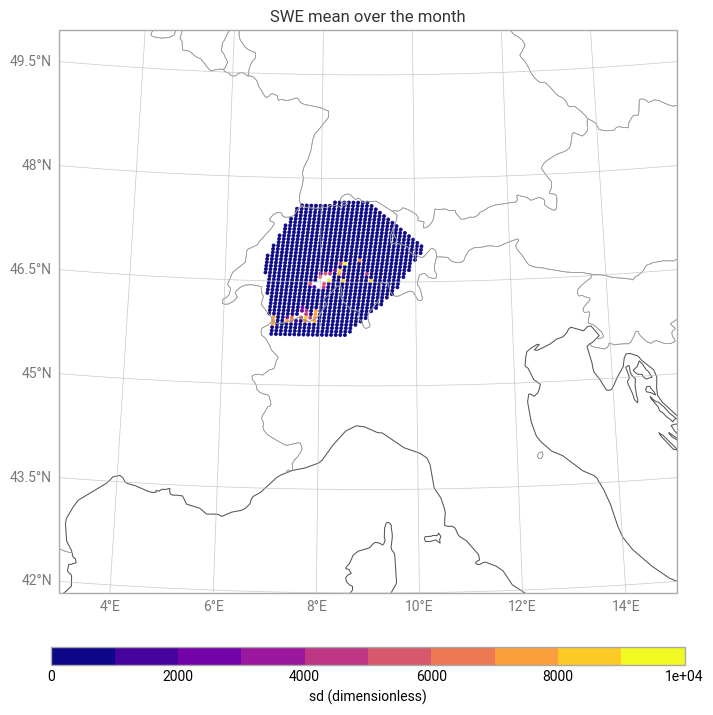

In [23]:
swe = swe_data.to_xarray()
swe ['sd']= swe['sd'] * 1000.0  # m -> mm
import earthkit.plots
chart = earthkit.plots.Map(domain=[3, 15, 42, 50])
chart.point_cloud(swe['sd'].mean(("datetimes")), x="longitude", y="latitude")

chart.coastlines()
chart.borders()
chart.gridlines()

chart.title("SWE mean over the month")

chart.legend()

chart.show()

## Temperature at 2mt

From the list of available parameters, we select now **2_mt** at the surface level (levtype = sfc). 

Using the metadata, we can extract the information required to formulate the HDA query and retrieve the desired product.

In [24]:
t2 = next(
    v for k, v in parameters.items()
    if "2_metre_temperature" in k.lower() and v.get("levtype") == "sfc"
)
t2

{'type': 'data',
 'unit': 'K',
 'long_name': '2 metre temperature',
 'shortName': '2t',
 'standard_name': '2_metre_temperature',
 'url': 'https://codes.ecmwf.int/grib/param-db/167',
 'parameter_ID': '167',
 'product_type': 'forecast',
 'levtype': 'sfc',
 'levelist': '',
 'time': 'Hourly'}

In [25]:
response = requests.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
 "collections": [COLLECTION_ID],
    "datetime": "2030-01-01T00:00:00Z/2030-01-30T23:00:00Z",
    "query":  {
    "ecmwf:resolution":{"eq": "high"},
    "ecmwf:levtype":{"eq":  t2["levtype"]},
    "ecmwf:time":{"eq": "1200"},
    "ecmwf:param":{"eq": t2["parameter_ID"]}
    },
    "intersects":Alps_central
})

In [26]:
if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

In [27]:

link = next((l for l in product.get('links', []) if l.get("rel") == "retrieve"), None)

if link:
    href = link.get("href")
    body = link.get("body")   # optional: depends on extension
    print("href:", href)
    print("body:", body)
else:
    print(f"No link with rel='{target_rel}' found")


href: https://hda.data.destination-earth.eu/stac/v2/collections/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-FESOM.R1/order
body: {'activity': 'ScenarioMIP', 'class': 'd1', 'dataset': 'climate-dt', 'date': '20300101/to/20300130', 'experiment': 'SSP3-7.0', 'expver': '0001', 'feature': {'shape': [[45.7, 7.0], [45.7, 8.5], [46.3, 9.5], [47.0, 10.2], [47.7, 9.0], [47.6, 7.5], [46.8, 6.8], [45.7, 7.0]], 'type': 'polygon'}, 'generation': '1', 'levtype': 'sfc', 'model': 'IFS-FESOM', 'param': '167', 'realization': '1', 'resolution': 'high', 'stream': 'clte', 'time': '1200', 'type': 'fc'}


In [28]:
#print(json.dumps(body, indent=4))

In [29]:

response = requests.post(href, json=body, headers=auth_headers)


if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")   


#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break

    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
 

Product ordered: fde355ff-f82e-4d65-8280-3e2afd5fe3f5
Provider: dedt_mn5
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: ordered
Polling 1/300
Polling 2/300
Polling 3/300
Polling 4/300
Polling 5/300
Polling 6/300
Polling 7/300
Polling 8/300
Polling 9/300
Polling 10/300
Polling 11/300
Polling 12/300
Polling 13/300
Polling 14/300
Product is ready to be downloaded.
Asset URL: https://hda-download.leonardo.data.destination-earth.eu/data/dedt_mn5/EO.ECMWF.DAT.D1.DT_CLIMATE.G1.SCENARIOMIP_SSP3-7.0_IFS-FESOM.R1/fde355ff-f82e-4d65-8280-3e2afd5fe3f5/downloadLink


In [30]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
    print ("content_disposition")
else:
    filename = os.path.basename(url)
    print ("baseurl")

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

content_disposition
downloading fde355ff-f82e-4d65-8280-3e2afd5fe3f5.covjson", attachment; 


1.76MB [00:00, 5.42MB/s]


In [31]:
import earthkit.data
import earthkit.maps

#filename='88fb152a-ee39-4be5-9f53-dac793d351e2.covjson'
#filename='bf4a7332-e341-4fcc-ad2b-0b7234b68015.covjson'
t2_data = earthkit.data.from_source("file", filename)

In [32]:
t2_data.to_xarray()

<xarray.Dataset> Size: 279kB
Dimensions:    (datetimes: 30, number: 1, steps: 1, points: 1017)
Coordinates:
  * datetimes  (datetimes) <U20 2kB '2030-01-01 12:00:00Z' ... '2030-01-30 12...
  * number     (number) int64 8B 0
  * steps      (steps) int64 8B 0
  * points     (points) int64 8kB 0 1 2 3 4 5 ... 1011 1012 1013 1014 1015 1016
    latitude   (points) float64 8kB 45.73 45.73 45.73 ... 47.65 47.65 47.65
    longitude  (points) float64 8kB 7.0 7.095 7.19 7.286 ... 8.791 8.891 8.99
    levelist   (points) float64 8kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    2t         (datetimes, number, steps, points) float64 244kB 273.4 ... 275.7
Attributes: (12/15)
    activity:     scenariomip
    class:        d1
    dataset:      climate-dt
    experiment:   ssp3-7.0
    expver:       0001
    generation:   1
    ...           ...
    resolution:   high
    stream:       clte
    type:         fc
    number:       0
    step:         0
    date:         2030-01-01 12:00:00Z

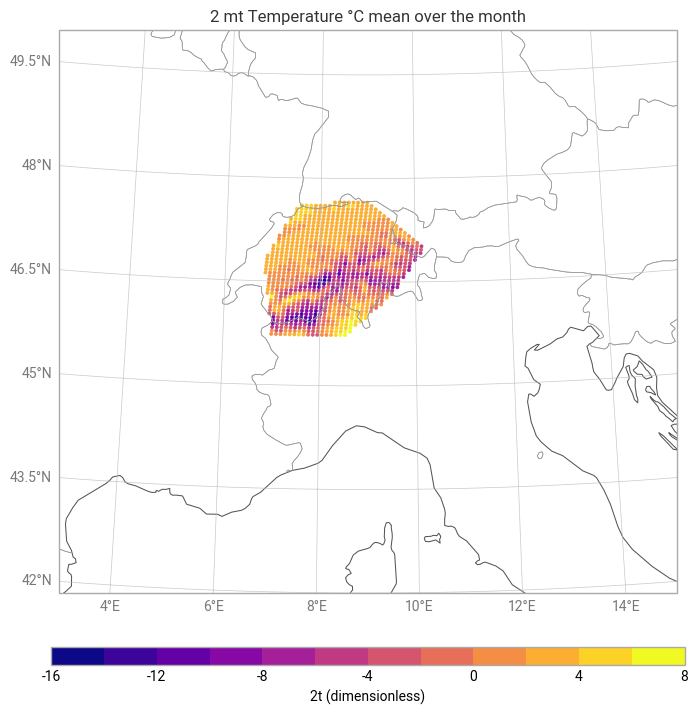

In [33]:
t2 = t2_data.to_xarray()
t2 ['2t']= t2['2t'] - 273.15  # K -> °C
import earthkit.plots
chart = earthkit.plots.Map(domain=[3, 15, 42, 50])
chart.point_cloud(t2['2t'].mean(("datetimes")), x="longitude", y="latitude")

chart.coastlines()
chart.borders()
chart.gridlines()

chart.title("2 mt Temperature °C mean over the month")

chart.legend()

chart.show()

In [34]:
#lon = t2['longitude'].values
#lat = t2['latitude'].values

## Inspect Time Coverage and Data Ranges

This cell provides a quick diagnostic summary of the loaded dataset. 

It prints the time coverage (all available timestamps) and reports the value ranges for the key variables—temperature and snow depth. 

These checks help confirm that the dataset has been loaded correctly, the temporal dimension matches expectations, and the physical variables fall within a reasonable range before proceeding with further analysis.

In [35]:
print("Time coverage:", t2.datetimes.values)
print("Temperature range:", float(t2["2t"].min()),
      float(t2["2t"].max()))
print("Snow depth range:", float(swe["sd"].min()),
      float(swe["sd"].max()))

Time coverage: ['2030-01-01 12:00:00Z' '2030-01-02 12:00:00Z' '2030-01-03 12:00:00Z'
 '2030-01-04 12:00:00Z' '2030-01-05 12:00:00Z' '2030-01-06 12:00:00Z'
 '2030-01-07 12:00:00Z' '2030-01-08 12:00:00Z' '2030-01-09 12:00:00Z'
 '2030-01-10 12:00:00Z' '2030-01-11 12:00:00Z' '2030-01-12 12:00:00Z'
 '2030-01-13 12:00:00Z' '2030-01-14 12:00:00Z' '2030-01-15 12:00:00Z'
 '2030-01-16 12:00:00Z' '2030-01-17 12:00:00Z' '2030-01-18 12:00:00Z'
 '2030-01-19 12:00:00Z' '2030-01-20 12:00:00Z' '2030-01-21 12:00:00Z'
 '2030-01-22 12:00:00Z' '2030-01-23 12:00:00Z' '2030-01-24 12:00:00Z'
 '2030-01-25 12:00:00Z' '2030-01-26 12:00:00Z' '2030-01-27 12:00:00Z'
 '2030-01-28 12:00:00Z' '2030-01-29 12:00:00Z' '2030-01-30 12:00:00Z']
Temperature range: -26.23211517333982 11.962083435058616
Snow depth range: 0.0 10000.0


## Compute daily SWE change (ΔSWE)

Compute daily SWE change:
ΔSWE=SWE(t)−SWE(t−1)

- Positive ΔSWE = snowfall accumulation
- Negative ΔSWE = melt / compaction

In [36]:
Delta_SWE = swe.diff('datetimes')
Delta_SWE.attrs['units'] = 'mm/day'

T_for_scatter = t2.isel(datetimes=slice(1, None))
SWE_for_scatter = swe.isel(datetimes=slice(1, None))
Delta_for_scatter = Delta_SWE

print("Days in month:", t2.datetimes.size)
print("Scatter samples:", T_for_scatter.datetimes.size)

Days in month: 30
Scatter samples: 29


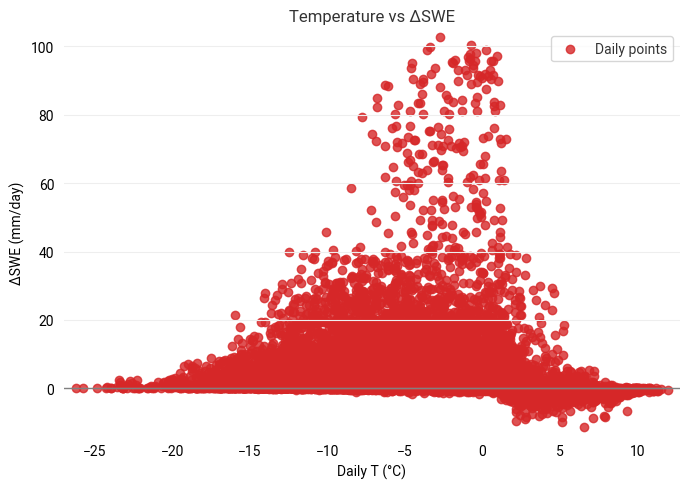

In [37]:
import numpy as np
# Build a DataFrame for statistics
import warnings
warnings.filterwarnings('ignore')

df = xr.merge([T_for_scatter, Delta_for_scatter]).to_dataframe().dropna()
plt.figure(figsize=(7,5))
plt.scatter(df['2t'], df['sd'], color='tab:red', alpha=0.8, label='Daily points')
plt.axhline(0, color='gray', lw=1)
plt.xlabel('Daily T (°C)')
plt.ylabel('ΔSWE (mm/day)')
plt.title(f'Temperature vs ΔSWE')
plt.legend()
plt.tight_layout()
plt.show()

## Summary

Throughout this notebook, we demonstrated how to query and download temperature and snow‑depth data from the HDA within a defined region of interest for a month at a certain hour.

We used Earthkit to load and visualize data. We inspected the dataset’s spatial and temporal coverage, performed unit conversions, and computed a monthly mean over the ROI. 

Finally, by examining the relationship between temperature and snow depth, we visualized their correlation highlighting how temperature fluctuations relate to snowpack variability. 

Overall, the workflow showcased a complete end‑to‑end approach—from data discovery and retrieval to visualization and statistical analysis—illustrating how HDA and Earthkit can be combined to efficiently explore climate variables over a specific region.

## Resources and references

<div class="alert alert-block alert-warning">
<b> References: </b><ul>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li><a href="https://hda.data.destination-earth.eu/docs">The HDA OpenAPI endpoint</a> </li> 
    <li> <a href="https://destine.ecmwf.int/climate-change-adaptation-digital-twin-climate-dt/">Climate Change Adaptation DT (Climate DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Climate+DT+Phase+1+data+catalogue">Climate DT data catalogue</a></li></ul>
<b> Credit: </b><ul>
    <li> Earthkit packages used in this context are provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li></ul>
</div>